# INFO 3950 Problem Set 7

name: Kate Li

netid: kl739

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1) Stylometrics w/ letter 3-grams
You should calculate the letter 3-gram features for each item as in lec21_l3g_sty.ipynb, with one modification. Calculate the most common features to use as usual, by counting the total number of occurrences in the training set, with no adjustments for file sizes. The set of most common features is based on occurrence in the first 640 training files throughout what follows.

But when using those to calculate the features for each individual text, divide the number counts by the length of the text (since the texts are of varying lengths, from roughly 5000 to 10000 characters, this will prevent the properties of longer texts from dominating). This was not necessary in the case of using 5000 word blocks in ps6, since those blocks were all the same length, but now you are using the full articles as the blocks and they have variable length so it is preferable to use a "density" of features.

Start with the standard Scaler applied to 4000 features, and as in [lec23_torch.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/lec23_torch.ipynb)
and [lec24_torch_mnist.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/lec24_torch_mnist.ipynb),
train a neural net with the following architecture: a Linear layer increasing the 4000 input features to 4096,followed by ReLU, and Dropout, then a second Linear layer reducing from 4096 to the output 20 (again followed by Dropout, but not Relu since it's the output).

### A. 
Train it on the 640 item training set described above, and test it on the 200 item test1 set.<br>
Use the same learning rate, loss_fn, and optimizer as in the lec24_torch_mnist.ipynb examples.

You should experiment with the values of the Dropouts, but you should find that with both Dropouts in the p=.75 range (i.e., high) that within (at most) a few hundred epochs of training you achieve accuracy on the test set in the above 80% range (where baseline guessing is 5%).

(The data set is small so epochs are rapid, but it takes more of them to train properly. Note that with such a small dataset it will be possible to overfit, so you can back off if you see that happening.)<br>
Make plots of i) the train and test losses, and ii) the train and test accuracies.

Note you need to use `model.eval()` to turn the dropout off (i.e., to use all neurons) in order to evaluate the model on either test or training data, and if in the middle of a training loop then turn it on again afterwards using `model.train()`, as in the lecture notebook examples. There will be additional discussion in lec25.

In [5]:
#conda install pytorch

In [6]:
import os
import re
from collections import Counter
from glob import glob
from sklearn import preprocessing
import torch
from torch import nn
from torchvision import transforms, datasets
#from torchsummary import summary
from torch.utils.data import DataLoader

In [7]:
# get top 4000 trigrams from first 640 training files
initials = ['bs','cb','db','fb','fm','gc','je','jb','jm','mc','md','mg','mr','nk','pk','rd','sb','te','tf','zt']
train_dir = './ps7data/train'
trigram_count = {}

all_files = []
for author in initials:
    author_dir = os.path.join(train_dir, author)
    all_files += sorted(glob(os.path.join(author_dir, '*.txt')))

all_files = all_files[:640]

overall_counter = Counter()
for file in all_files:
    text = open(file, 'r').read().lower()
    trigrams = [text[i:i+3] for i in range(len(text) - 2)]
    overall_counter.update(trigrams)

top4000 = [trigram for trigram, _ in overall_counter.most_common(4000)]

In [8]:
def vectorize(text, top_trigrams):
    text = text.lower()
    trigrams = [text[i:i+3] for i in range(len(text) - 2)]
    tri_counts = Counter(trigrams)
    vector = np.array([tri_counts[trigram] / len(text) for trigram in top_trigrams])
    return vector

In [9]:
X_train = []
y_train = []
label_map = {initial: i for i, initial in enumerate(initials)}

for author in initials:
    author_dir = os.path.join(train_dir, author)
    files = sorted(glob(os.path.join(author_dir, '*.txt')))

    for file in files:
        text = open(file).read()
        vector = vectorize(text, top4000)
        X_train.append(vector)
        y_train.append(label_map[author])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape, y_train.shape

((640, 4000), (640,))

In [10]:
X_test = []
y_test = []

for author in initials:
    author_dir = os.path.join('ps7data/test1', author)
    files = sorted(glob(os.path.join(author_dir, '*.txt')))

    for file in files:
        text = open(file).read()
        vector = vectorize(text, top4000)
        X_test.append(vector)
        y_test.append(label_map[author])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape, y_test.shape

((200, 4000), (200,))

In [11]:
scaler = preprocessing.StandardScaler()

nn_model = nn.Sequential(
    nn.Flatten(),
    
    nn.Linear(4000, 4096),
    nn.ReLU(),
    nn.Dropout(0.75),

    nn.Linear(4096, 20),
    nn.Dropout(0.75)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [12]:
X_train_scaled = scaler.fit_transform(X_train[:, :4000])
X_test_scaled = scaler.transform(X_test[:, :4000])

In [13]:
inp = torch.tensor([1.0, 2.0, 3, 4, 5])

nn.Dropout(p=0.4)(inp)

tensor([1.6667, 0.0000, 5.0000, 6.6667, 0.0000])

In [14]:
X_train_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train).long()

X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test).long()

In [15]:
epochs = 80
scores = []
losses = []
test_losses = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    nn_model.train() #turns on dropout
    # Compute prediction and loss
    pred = nn_model(X_train_tensor)
    loss = loss_fn(pred, y_train_tensor)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    nn_model.eval()  #turns off dropout
    test_pred = nn_model(X_test_tensor)
    test_loss = loss_fn(test_pred, y_test_tensor)
    losses.append((loss.item(), test_loss.item()))
                  
    train_score = (nn_model(X_train_tensor).argmax(1) == y_train_tensor).sum().item() / len(y_train)
    test_score = (nn_model(X_test_tensor).argmax(1) == y_test_tensor).sum().item() / len(y_test)
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores.append((train_score, test_score))

Epoch 1: loss=3.441, training_score=56.9%, test_score=39.5%
Epoch 2: loss=2.760, training_score=81.6%, test_score=59.0%
Epoch 3: loss=2.443, training_score=90.8%, test_score=66.5%
Epoch 4: loss=2.396, training_score=94.4%, test_score=73.5%
Epoch 5: loss=2.152, training_score=97.2%, test_score=72.5%
Epoch 6: loss=2.184, training_score=98.8%, test_score=74.5%
Epoch 7: loss=2.077, training_score=99.2%, test_score=75.5%
Epoch 8: loss=2.061, training_score=99.4%, test_score=77.5%
Epoch 9: loss=2.149, training_score=99.7%, test_score=79.5%
Epoch 10: loss=2.142, training_score=100.0%, test_score=79.5%
Epoch 11: loss=2.043, training_score=100.0%, test_score=79.5%
Epoch 12: loss=2.033, training_score=100.0%, test_score=81.0%
Epoch 13: loss=2.046, training_score=100.0%, test_score=80.5%
Epoch 14: loss=2.092, training_score=100.0%, test_score=82.0%
Epoch 15: loss=2.039, training_score=100.0%, test_score=83.0%
Epoch 16: loss=2.121, training_score=100.0%, test_score=83.0%
Epoch 17: loss=2.058, trai

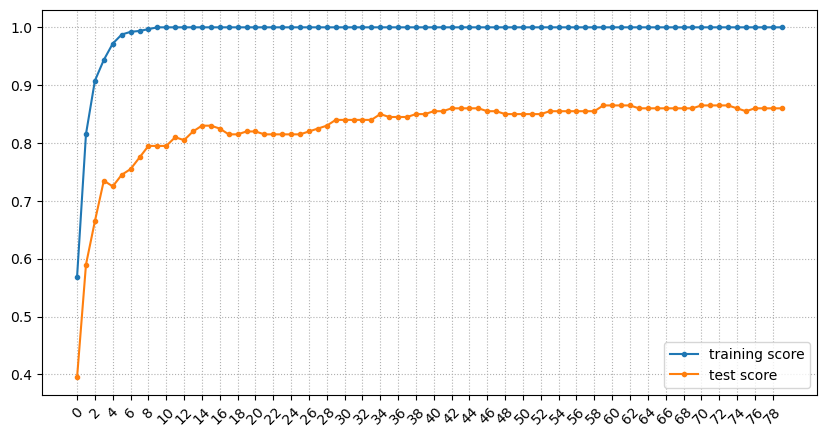

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(range(len(scores)), *np.array(scores).T, marker='.')
plt.xticks(range(0,len(scores),2))
plt.xticks(rotation = 45)
plt.grid(ls=':')
plt.legend(['training score','test score']);

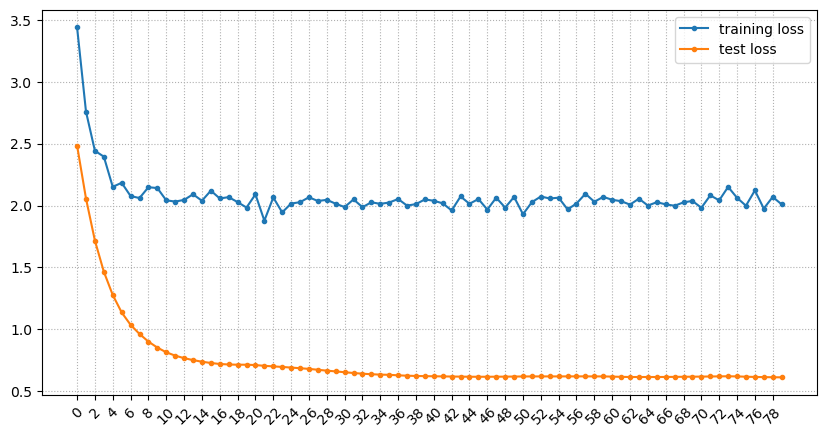

In [17]:
plt.figure(figsize = (10, 5))
plt.plot(range(len(losses)), *np.array(losses).T, marker='.')
plt.xticks(range(0,len(losses),2))
plt.xticks(rotation = 45)
plt.grid(ls=':')
plt.legend(['training loss','test loss']);

### B.
Now consider the additional 40 files 00.txt -- 39.txt in the subdirectory test2/ (with y_test2 values given n the file y_test2.py). These are texts from a year ago, whereas the earlier 640+200=840 texts were from over two years ago. A question is whether there may have been stylistic drift of some of the columnists in the past two years, causing more author confusion.

Reinitialize the above network and instead train it on the combined 640+200 items from the training and test1 sets, and test it on the 40 item test2 set. The correct labels are given in the file y_test2.py. With (high) values of both dropouts as in part A, you should find that your network performs even better than in part A, after an even smaller number of epochs.

[As a bonus, feel free to determine why this works so well, i.e., which are the primary discriminating features for the different authors.]

In [19]:
X_train2 = np.concatenate([X_train, X_test], axis = 0)
y_train2 = np.concatenate([y_train, y_test], axis = 0)

In [20]:
X_test2 = []
exec(open('ps7data/y_test2.py').read())
test2_dir = 'ps7data/test2'

for i in range(40):
    file = os.path.join(test2_dir, f'{i:02d}.txt')
    text = open(file).read()
    vector = vectorize(text, top4000)
    X_test2.append(vector)

X_test2 = np.array(X_test2)
y_test2 = np.array(y_test2)
X_test2.shape, y_test2.shape

((40, 4000), (40,))

In [21]:
model2 = nn.Sequential(
    nn.Flatten(),
    
    nn.Linear(4000, 4096),
    nn.ReLU(),
    nn.Dropout(0.75),

    nn.Linear(4096, 20),
    nn.Dropout(0.75)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [22]:
X_train_scaled2 = scaler.fit_transform(X_train2)
X_train_tensor2 = torch.tensor(X_train_scaled2).float()

y_train_tensor2 = torch.tensor(y_train2).long()

X_test_scaled2 = scaler.transform(X_test2)
X_test_tensor2 = torch.tensor(X_test_scaled2).float()

y_test2_num = np.array([label_map[label] for label in y_test2])
y_test_tensor2 = torch.tensor(y_test2_num).long()

In [23]:
epochs = 20
scores = []
losses = []
test_losses = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    model2.train() #turns on dropout
    # Compute prediction and loss
    pred = model2(X_train_tensor2)
    loss = loss_fn(pred, y_train_tensor2)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model2.eval()  #turns off dropout
    test_pred = model2(X_test_tensor2)
    test_loss = loss_fn(test_pred, y_test_tensor2)
    losses.append((loss.item(), test_loss.item()))
                  
    train_score = (model2(X_train_tensor2).argmax(1) == y_train_tensor2).sum().item() / len(y_train2)
    test_score = (model2(X_test_tensor2).argmax(1) == y_test_tensor2).sum().item() / len(y_test2)
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores.append((train_score, test_score))

Epoch 1: loss=3.502, training_score=66.7%, test_score=55.0%
Epoch 2: loss=2.703, training_score=85.6%, test_score=65.0%
Epoch 3: loss=2.510, training_score=93.2%, test_score=82.5%
Epoch 4: loss=2.306, training_score=95.5%, test_score=82.5%
Epoch 5: loss=2.204, training_score=96.9%, test_score=82.5%
Epoch 6: loss=2.109, training_score=97.6%, test_score=85.0%
Epoch 7: loss=2.117, training_score=98.5%, test_score=87.5%
Epoch 8: loss=2.097, training_score=99.0%, test_score=87.5%
Epoch 9: loss=2.183, training_score=99.4%, test_score=87.5%
Epoch 10: loss=2.029, training_score=99.6%, test_score=87.5%
Epoch 11: loss=2.050, training_score=99.6%, test_score=90.0%
Epoch 12: loss=2.042, training_score=99.8%, test_score=92.5%
Epoch 13: loss=2.067, training_score=99.8%, test_score=92.5%
Epoch 14: loss=1.985, training_score=99.9%, test_score=92.5%
Epoch 15: loss=2.054, training_score=100.0%, test_score=90.0%
Epoch 16: loss=2.034, training_score=100.0%, test_score=90.0%
Epoch 17: loss=2.014, training_

### C.
To check for additional time-dependent drift, consider the additional 72 files 00.txt -- 71.txt in the subdirectory test3/ . These are texts from the past few months, including many from this month (Apr 2025). 
i) Use the classifier trained in part B (on the 640+200=840 texts from part A) to predict authors for these additional 72 texts.

The first (00.txt) should be predicted correctly as 'zt' and the last (71.txt) should be predicted correctly as 'bs'. (You could confirm these by looking at the texts themselves, and plugging any distinctive sentence into your favorite search engine to find the source editorial at nytimes.com ). For the purpose of grading, let `y_pred` be your 72 predictions and use `Counter(y_pred).most_common()` to list the results in the form `('bs', 3), ('zt', 2), ...` (whatever the actual numbers are).

In [25]:
X_test3 = []
test3_dir = 'ps7data/test3'

for i in range(72):
    file = os.path.join(test3_dir, f'{i:02d}.txt')
    text = open(file).read()
    vector = vectorize(text, top4000)
    X_test3.append(vector)

X_test3 = np.array(X_test3)
X_test3.shape

(72, 4000)

In [26]:
X_test_scaled3 = scaler.transform(X_test3)
X_test_tensor3 = torch.tensor(X_test_scaled3).float()

In [27]:
model2.eval()
y_pred = []
reverse_label_map = {i: initial for initial, i in label_map.items()}  

for i in range(len(X_test_tensor3)):
    pred = model2(X_test_tensor3[i:i+1])
    pred_label = pred.argmax(1).item()
    pred_initial = reverse_label_map[pred_label]
    y_pred.append(pred_initial)

results = Counter(y_pred).most_common()
print(results)

[('nk', 8), ('db', 6), ('pk', 5), ('rd', 5), ('mr', 5), ('md', 5), ('jb', 5), ('gc', 5), ('fb', 5), ('zt', 4), ('cb', 4), ('bs', 4), ('tf', 3), ('mg', 3), ('mc', 2), ('jm', 2), ('fm', 1)]


In [28]:
print(f"first [00] text prediction: {y_pred[0]}")
print(f"last [71] text prediction: {y_pred[71]}")

first [00] text prediction: zt
last [71] text prediction: nk


## 2)

### A. 
Cell [19] of [lec24_torch_mnist.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/lec24_torch_mnist.ipynb) gives the number of parameters for each layer of the '99.1%' model III.<br>
Explain what the numbers mean in terms of weights and biases.<br>
(For example, the last layer which takes 1024 neurons to the ten output neurons has ten objects each of the form $wx+b$ so there are 10 biases $b_i$ feeding into the $i^{\rm th}$ output neuron, but $x$ is a list of 1024 features so each of the 10 associated $w$'s has weights for 1024 items, a total of 10240 parameters.)

torch.Size([32, 1, 5, 5]) 800
- This is the first convolutional layer which has 32 filters, each with 5x5 weights, and 1 output channel. Since the weight is 5x5 = 25 and there are 32 filters, this means that there are 32*25 = 800 parameters.

torch.Size([32]) 32
- There are 32 filters, and each filter has a bias value of 1. Therefore, there are 32*1 = 32 parameters.

torch.Size([64, 32, 5, 5]) 51200
- This is the second convolutional layer which has 64 filters that each take inputs from the 32 filters from the first layer. Each filter now has 32*5*5 weights. With 64 filters, there are now 64*800 = 51200 parameters. 

torch.Size([64]) 64
- There are 64 filters, and again each filter has a bias value of 1. Therefore, there are 64*1 = 64 parameters.

torch.Size([10, 1024]) 10240
- The last layer takes 1024 neurons to the 10 output neurons, meaning there are 1024 weights per neuron. Since there are 10 neurons, there are 1024*10 = 10240 parameters.

torch.Size([10]) 10
- There are 10 filters, and each filter has a bias value of 1. Therefore, there are 10*1 = 10 parameters.

### B. 
Do the same parameter counts, with interpretations, and find the total number of parameters for:<br>
i) the '98.1%' model II in cell [9] of lec24_torch_mnist.ipynb

nn.Linear(28*28,128)
- This layer has 128 nodes with 28x28 input pixels (784 pixels). This means there are 128 nodes with 784 weights per node, equating to 128*784 = 100352 weight parameters. Since there are 128 output nodes, there are 128 bias terms. 100352 weight parameters and 128 bias terms means there are 100480 total parameters. 

nn.Linear(128,10)
- This layer connects 128 input nodes to 10 output nodes. This means there are 10 nodes with 128 weights per node, equating to 10*128 = 1280 weight parameters. Since there are 10 output nodes, there are 10 bias terms. 1280 weight parameters and 10 bias terms means there are 1290 total parameters. 

ii) the model in problem 1 above

nn.Conv2d(1, 32, kernel_size=5)
- This specifies learning 32 separate 5x5 filters. Each of these filters have a 24x24 output image which are considered to be separate channels. Since there are 32 filters and each filter is 5x5, the weights equal 32 * 5 * 5 = 800. Since there are 32 filters, there are 32 biases. 800 weight parameters and 32 biases means there are 832 total parameters. 

nn.Conv2d(32, 64, kernel_size=5)
- This layer takes 32 input channels and outputs 64 separate filters. Each of the 64 filters has a 5x5 window from the 32 inputs. Each filter has 800 weights (5 * 5 * 32). Therefore, there are 64*800 = 51200 weight parameters. Since there are 64 output filters, there are 64 bias terms. 51200 weight parameters and 64 bias terms means there are 51264 total parameters. 

nn.Linear(64 * 4 * 4, 10)
- This layer has 10 output nodes with 64 * 4 * 4 = 1024 input nodes. This means there are 10*1024 = 10240 weight parameters. Since there are 10 output nodes, there are 10 bias terms. 10240 weight parameters and 10 bias terms means there are 10250 total parameters.

## 3)
Lectures 24-25 (see
[lec24_torch_mnist.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/lec24_torch_mnist.ipynb)
and [lec25_mnist_cifar10.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2025sp/lec25_mnist_cifar10.ipynb) ) considered four models for the 28x28 [MNIST](https://en.wikipedia.org/wiki/MNIST_database) classification task, with increasing test accuracies of 92.6%, 98.1%, 99.1%, 99.7%. (A 20 year history of progress is given in the above wikipedia link, with the comment "Some images in the testing dataset are barely readable and may prevent reaching test error rates of 0%". The best current result is the 99.91% reported for the "ensemble of ensembles" in table 3 of [arXiv:2008.10400](https://arxiv.org/abs/2008.10400)).<br>
The methods used for this task are now ubiquitious in other applications, including general image classification, face recognition, text classification, generation, and translation, self-driving cars, medical diagnostics, and so on.

In [37]:
train_data = datasets.MNIST(
    root="./",
    train=True,
    #download=True,
    transform=transforms.ToTensor()
)

In [38]:
# Test data
test_data = datasets.MNIST(
    root="./",
    train=False,
#    download=True, #already downloaded with train data above
    transform=transforms.ToTensor()
)

In [39]:
# Dataloaders
batch_size = 64 #32 #128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

### A.

**i.** Evaluate the test score on the 10,000 image MNIST test data (you should find 98% or above)

In [42]:
model2 = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(4,4)),
    nn.ReLU(),

    nn.Flatten(),

    nn.Linear(25*25*8, 10)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [43]:
epochs = 15  #about four seconds per epoch
scores2 = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    model2.train() #turns on dropout
    for batch,(x, y) in enumerate(train_loader):
        # Compute prediction and loss
        pred = model2(x)
        loss = loss_fn(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()  #turns off dropout
    with torch.no_grad():
        X_train = train_data.data.unsqueeze(1).float() / 255
        X_test = test_data.data.unsqueeze(1).float() / 255

        train_pred = model2(X_train).argmax(1)
        test_pred = model2(X_test).argmax(1)

        train_score = (train_pred == train_data.targets).sum().item() / len(train_data)
        test_score = (test_pred == test_data.targets).sum().item() / len(test_data)
    
    #train_score = (model2(train_data.data.float()).argmax(1) == train_data.targets).sum().item() / len(train_data)
    #test_score = (model2(test_data.data.float()).argmax(1) == test_data.targets).sum().item() / len(test_data)
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores2.append((train_score, test_score))

Epoch 1: loss=0.045, training_score=97.4%, test_score=97.3%
Epoch 2: loss=0.196, training_score=97.9%, test_score=97.4%
Epoch 3: loss=0.026, training_score=98.7%, test_score=98.1%
Epoch 4: loss=0.055, training_score=98.8%, test_score=98.1%
Epoch 5: loss=0.098, training_score=99.0%, test_score=98.2%
Epoch 6: loss=0.014, training_score=99.2%, test_score=98.2%
Epoch 7: loss=0.009, training_score=99.4%, test_score=98.2%
Epoch 8: loss=0.022, training_score=99.4%, test_score=98.3%
Epoch 9: loss=0.014, training_score=99.3%, test_score=98.0%
Epoch 10: loss=0.011, training_score=99.6%, test_score=98.3%
Epoch 11: loss=0.014, training_score=99.6%, test_score=98.4%
Epoch 12: loss=0.002, training_score=99.5%, test_score=98.1%
Epoch 13: loss=0.040, training_score=99.6%, test_score=98.2%
Epoch 14: loss=0.001, training_score=99.8%, test_score=98.5%
Epoch 15: loss=0.000, training_score=99.6%, test_score=98.0%


**ii.** Visualize the eight 4x4 filters you've trained (they can be in two rows of four), as was done for the 32 5x5 filters in cell [24] of lec24_torch_mnist.ipynb for model III. Try to identify some filters that detect horizontal, vertical, and diagonal edges.

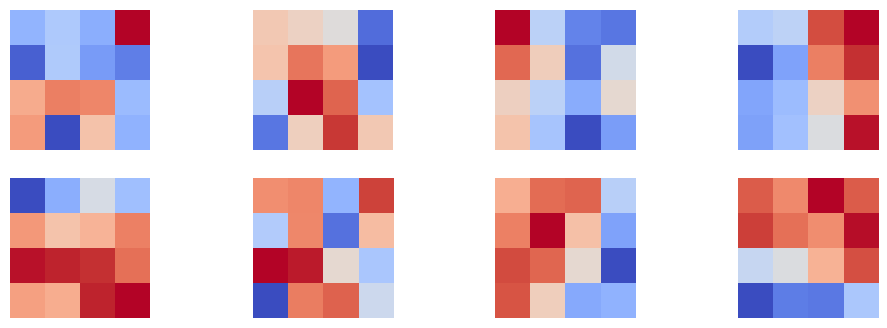

In [45]:
plt.figure(figsize=(12,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(list(model2.parameters())[0][i][0].detach().numpy(), cmap='coolwarm')
    plt.axis('off')

likely detecting vertical edges: third column in first row or top right <br>
likely detecting horizontal edges: bottom left or top left <br>
likely detecting diagonal edges: second column in first row or third column in second row<br>

**iii.** Now visualize the output of the convolutional layer, as in cell [29] of lec24_torch_mnist.ipynb, except now there are only eight filters, so more training examples can be considered. It could look something like the below
(which uses training samples [1,3,5,7,2,0,13,15,17,4] to have ten digits in sequence, and where f0-f7 designate the outputs from the eight filters). E.g., in the below f0 appears optimized for roughly horizontal edges, and f2 for roughly vertical.

Check whether the tentative filter identifications in part ii are consistent with the output you find for the layer, and see whether by looking at the outputs you can intuit the roles of any other of the filters.

In [48]:
digit_indices = [-1] * 10

for index, label in enumerate(train_data.targets):
    digit = int(label)
    if digit_indices[digit] == -1:
        digit_indices[digit] = index

In [49]:
layer0_output = model2[0](train_data.data[digit_indices].unsqueeze(1).float())
layer1_output = model2[1](layer0_output) 

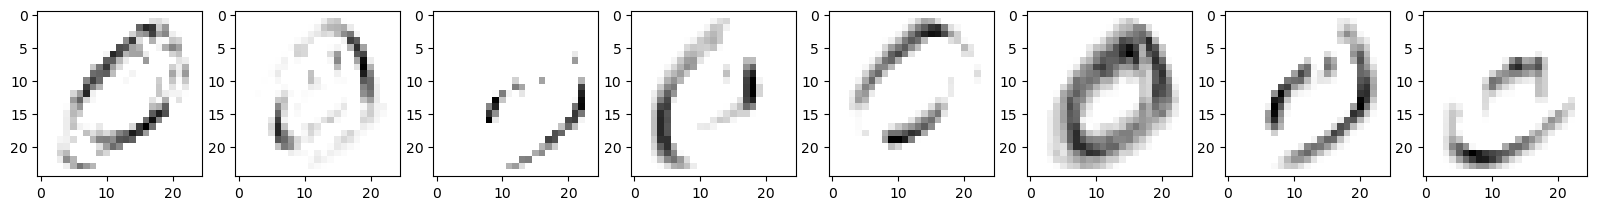

In [50]:
plt.figure(figsize=(20,10))
for k in range(8):
   plt.subplot(4,8,k+1)
   plt.imshow(layer1_output[0,k].detach().numpy(), cmap='binary')

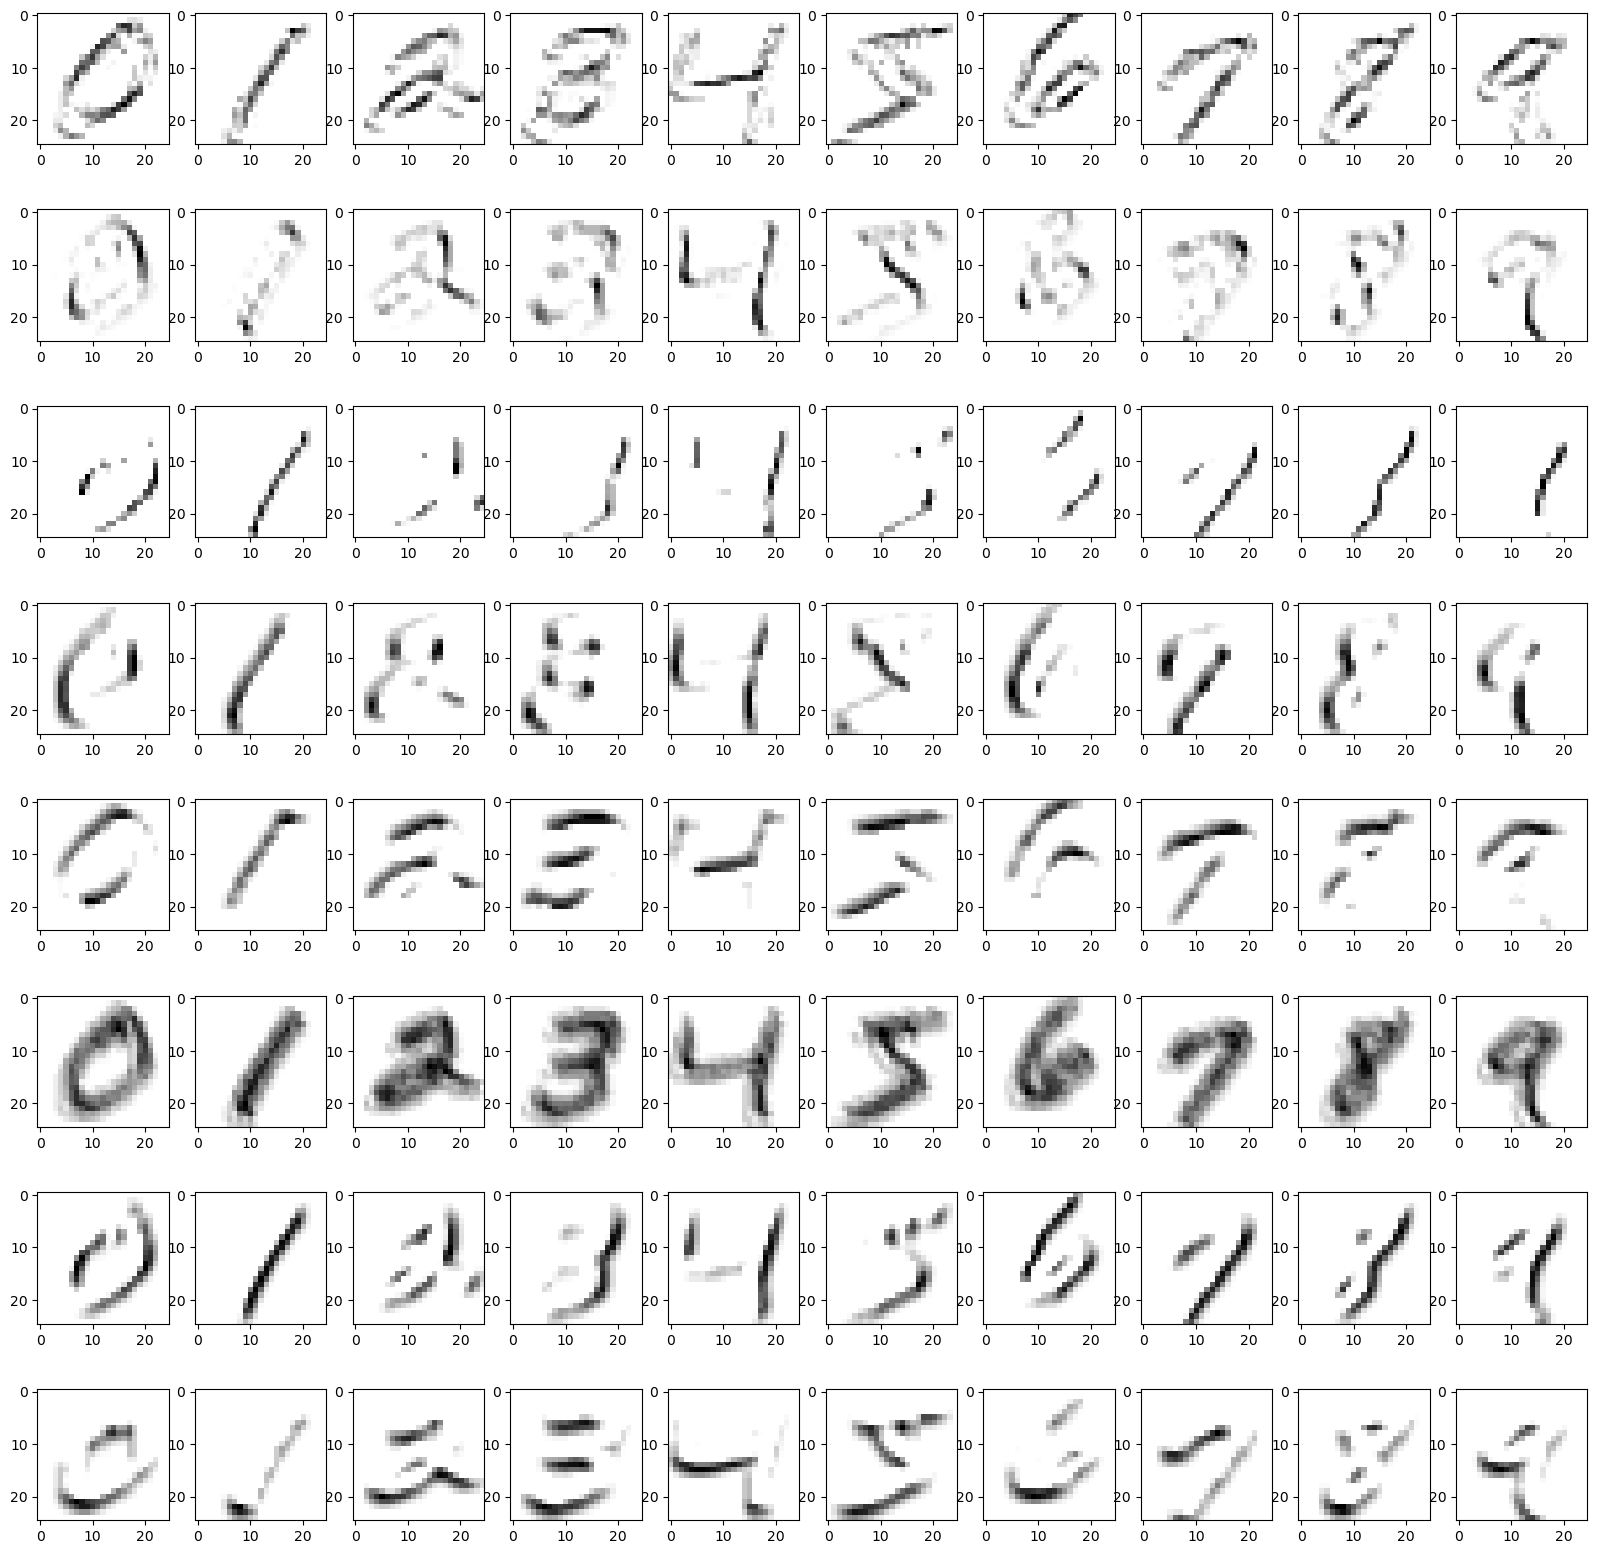

In [51]:
plt.figure(figsize=(20, 20))
for j in range(8):
    for i in range(10):
        plt.subplot(8, 10, j * 10 + i + 1)
        plt.imshow(layer1_output[i, j].detach().numpy(), cmap='binary')

My visualizations from part ii seem to align well with the outputs shown here. For the visualizations that likely detect vertical lines (3rd or 4th filter), there are more vertical edges. The same can be said for those detecting horizontal lines (1st or 5th filter). For those that detect diagonal lines, our images correspond by showing more color across the diagonal. 

### B.

Now add a `nn.Dropout(.2)` layer after the `nn.Flatten()` layer (so that 20% of the neuron outputs in that layer are randomly ignored each training pass).

In [54]:
model2 = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(4,4)),
    nn.ReLU(),

    nn.Flatten(),
    nn.Dropout(0.2),

    nn.Linear(25*25*8, 10)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [55]:
epochs = 15  #about four seconds per epoch
scores2 = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    model2.train() #turns on dropout
    for batch,(x, y) in enumerate(train_loader):
        # Compute prediction and loss
        pred = model2(x)
        loss = loss_fn(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()  #turns off dropout
    with torch.no_grad():
        X_train = train_data.data.unsqueeze(1).float() / 255
        X_test = test_data.data.unsqueeze(1).float() / 255

        train_pred = model2(X_train).argmax(1)
        test_pred = model2(X_test).argmax(1)

        train_score = (train_pred == train_data.targets).sum().item() / len(train_data)
        test_score = (test_pred == test_data.targets).sum().item() / len(test_data)
    
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores2.append((train_score, test_score))

Epoch 1: loss=0.131, training_score=96.5%, test_score=96.5%
Epoch 2: loss=0.387, training_score=97.8%, test_score=97.4%
Epoch 3: loss=0.163, training_score=98.4%, test_score=98.0%
Epoch 4: loss=0.034, training_score=98.5%, test_score=98.1%
Epoch 5: loss=0.095, training_score=98.7%, test_score=98.1%
Epoch 6: loss=0.135, training_score=98.8%, test_score=98.2%
Epoch 7: loss=0.002, training_score=99.0%, test_score=98.2%
Epoch 8: loss=0.064, training_score=99.2%, test_score=98.3%
Epoch 9: loss=0.054, training_score=99.2%, test_score=98.2%
Epoch 10: loss=0.010, training_score=99.3%, test_score=98.3%
Epoch 11: loss=0.041, training_score=99.3%, test_score=98.2%
Epoch 12: loss=0.107, training_score=99.5%, test_score=98.4%
Epoch 13: loss=0.016, training_score=99.4%, test_score=98.3%
Epoch 14: loss=0.004, training_score=99.6%, test_score=98.4%
Epoch 15: loss=0.002, training_score=99.6%, test_score=98.4%


### C.

In [57]:
model2 = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(4,4)),
    nn.ReLU(),

    nn.Conv2d(8, 16, kernel_size=(2, 2)),
    nn.ReLU(),

    nn.Flatten(),
    nn.Dropout(0.5),

    nn.Linear(16*24*24, 10)
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

**i.** Using a batchsize of 64, train the model for 15 epochs, and evaluate on the MNIST x_test data. You should now find a score above 98.5%.
(Again feel free to experiment with the dropout rate.)

In [59]:
epochs = 15  #about four seconds per epoch
scores2 = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    model2.train() #turns on dropout
    for batch,(x, y) in enumerate(train_loader):
        # Compute prediction and loss
        pred = model2(x)
        loss = loss_fn(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()  #turns off dropout
    with torch.no_grad():
        X_train = train_data.data.unsqueeze(1).float() / 255
        X_test = test_data.data.unsqueeze(1).float() / 255

        train_pred = model2(X_train).argmax(1)
        test_pred = model2(X_test).argmax(1)

        train_score = (train_pred == train_data.targets).sum().item() / len(train_data)
        test_score = (test_pred == test_data.targets).sum().item() / len(test_data)
    
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores2.append((train_score, test_score))

Epoch 1: loss=0.076, training_score=97.2%, test_score=97.4%
Epoch 2: loss=0.156, training_score=98.1%, test_score=98.0%
Epoch 3: loss=0.123, training_score=98.6%, test_score=98.4%
Epoch 4: loss=0.081, training_score=98.9%, test_score=98.7%
Epoch 5: loss=0.014, training_score=98.9%, test_score=98.5%
Epoch 6: loss=0.026, training_score=99.1%, test_score=98.6%
Epoch 7: loss=0.114, training_score=99.1%, test_score=98.6%
Epoch 8: loss=0.017, training_score=99.4%, test_score=98.7%
Epoch 9: loss=0.005, training_score=99.4%, test_score=98.9%
Epoch 10: loss=0.046, training_score=99.5%, test_score=98.9%
Epoch 11: loss=0.002, training_score=99.6%, test_score=98.8%
Epoch 12: loss=0.004, training_score=99.5%, test_score=98.9%
Epoch 13: loss=0.155, training_score=99.7%, test_score=98.9%
Epoch 14: loss=0.212, training_score=99.7%, test_score=98.8%
Epoch 15: loss=0.024, training_score=99.7%, test_score=98.8%


**ii)** Visualize the outputs of the 2nd layer of filters for this model.<br>
Some might be interpretable as in part Aiii (i.e., horizontal/vertical/diagonal line segments), but others might be less obvious, i.e., detecting some composite features. Try to identify some of the latter type and intuit any higher level features of the images they're detecting.

In [61]:
layer0_output = model2[0](train_data.data[digit_indices].unsqueeze(1).float())
layer1_output = model2[1](layer0_output) 
layer2_output = model2[2](layer1_output)
layer3_output = model2[3](layer2_output)

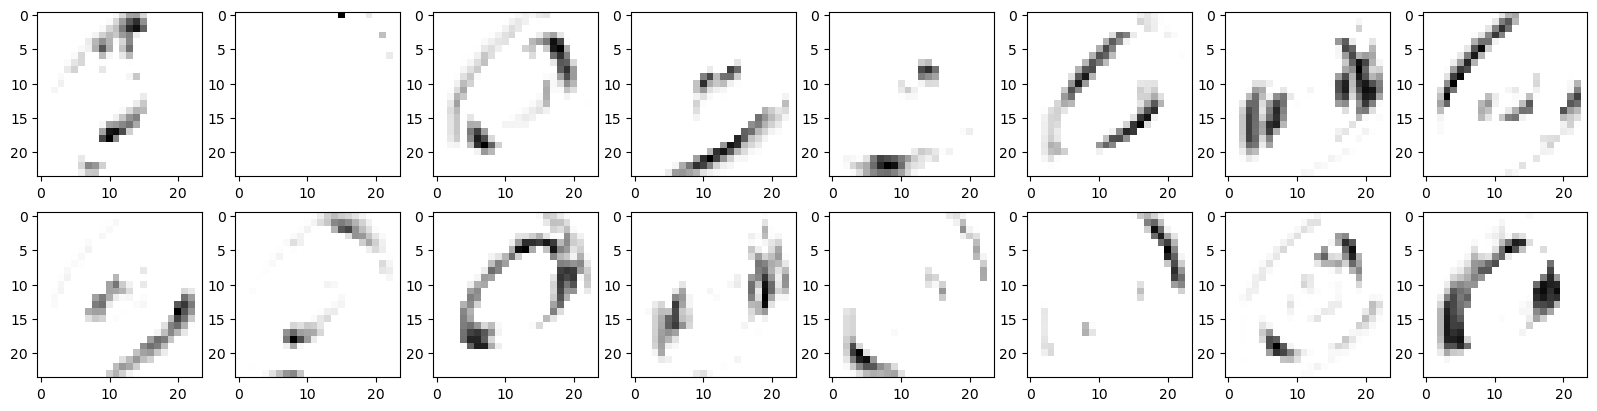

In [62]:
plt.figure(figsize=(20, 10))
for k in range(layer3_output.shape[1]):
   plt.subplot(4,8,k+1)
   plt.imshow(layer3_output[0,k].detach().numpy(), cmap='binary')

Based on these filters, I think the 8th filter really shows light colors on the bottom left and top right edges of the digit. There are a few filters that show darker colors on those same edges (i.e. 3, 5, 7), so it is flipped with the 8th filter. I've displayed the filters for all of the digits below and more of the effects from these filters on the second layer can be seen.

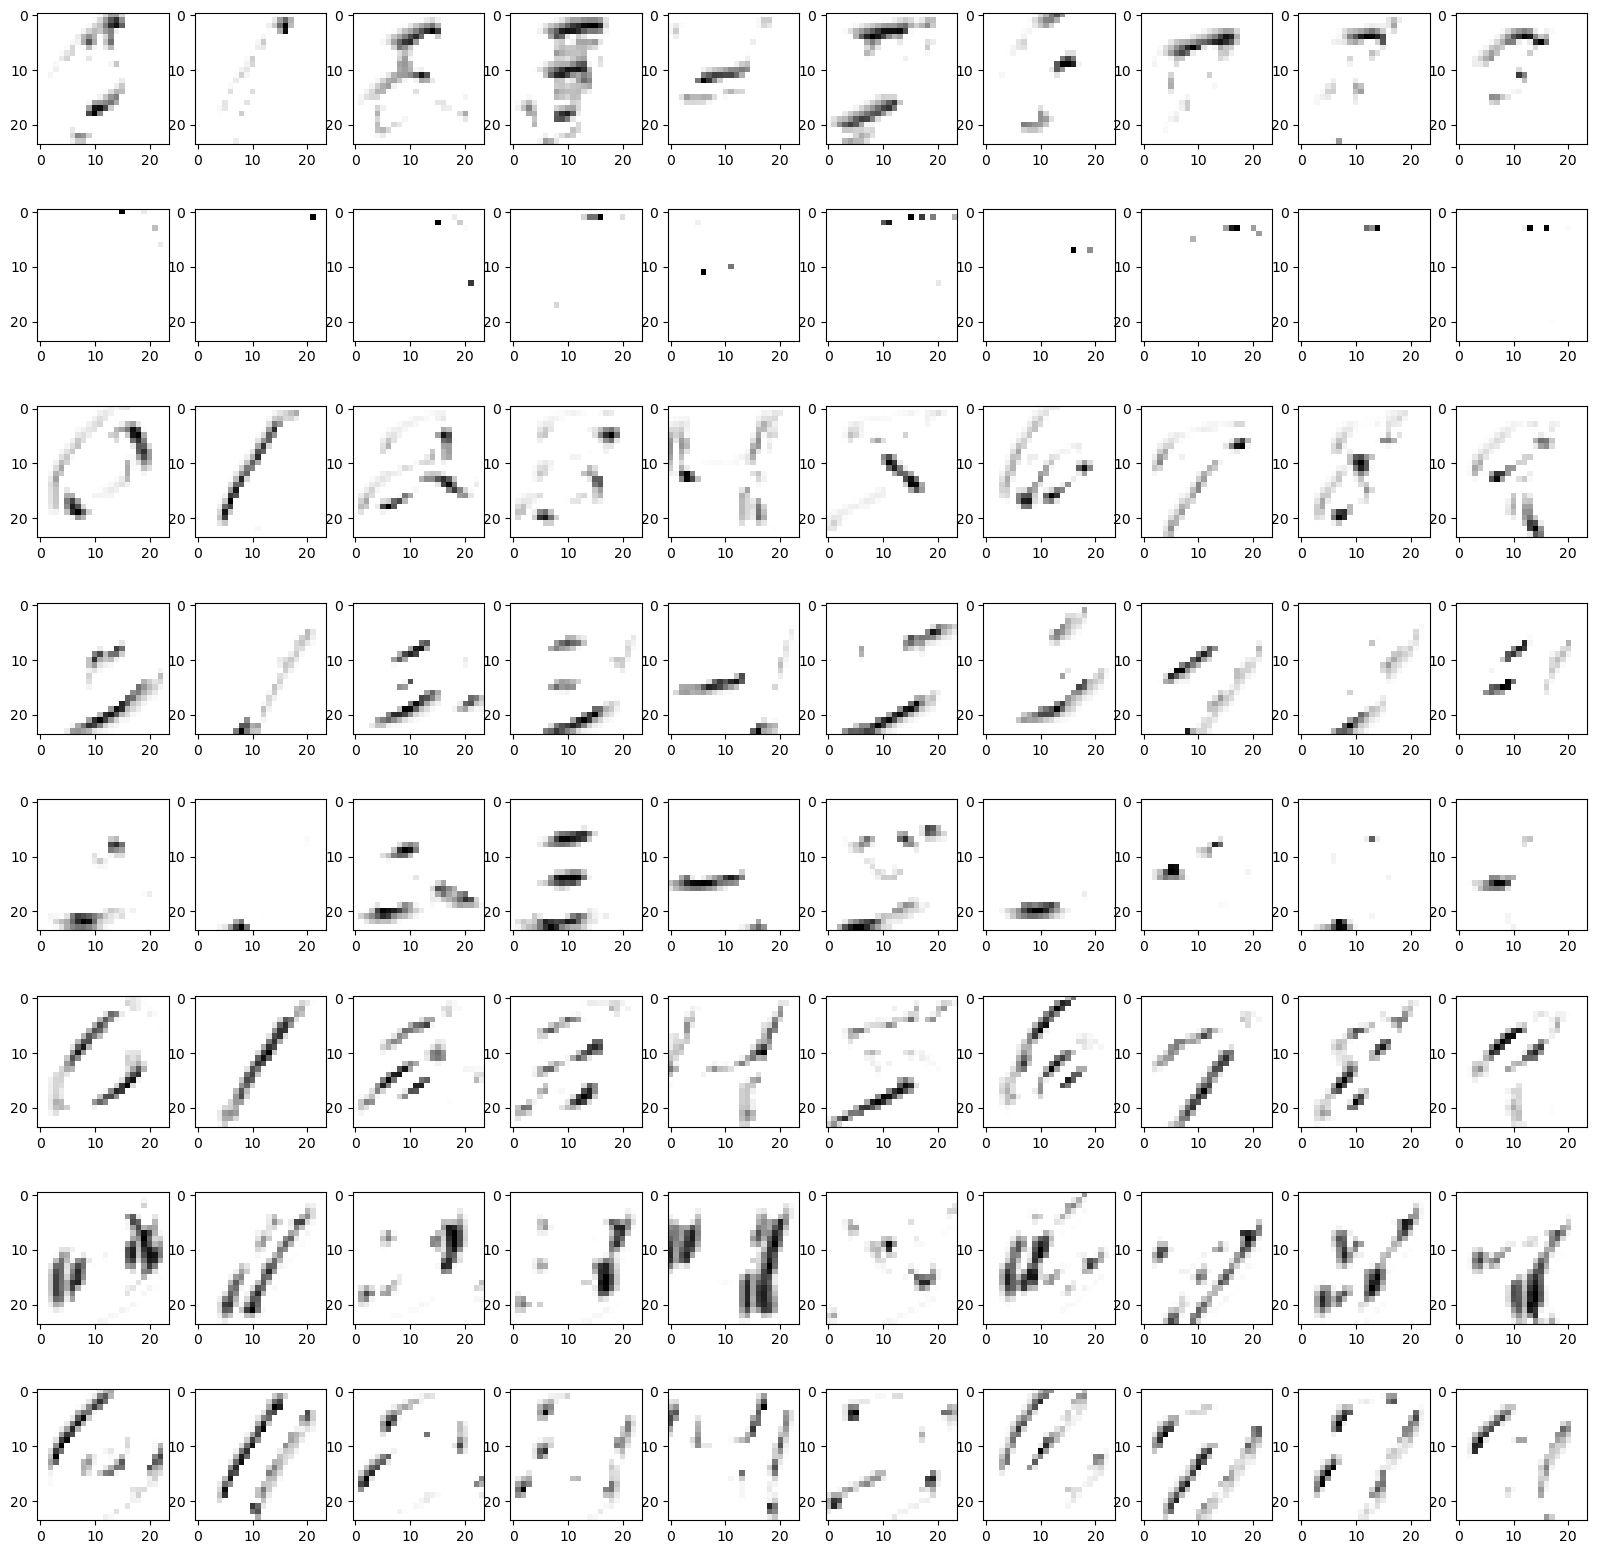

In [64]:
plt.figure(figsize=(20, 20))
for j in range(8):
    for i in range(10):
        plt.subplot(8, 10, j * 10 + i + 1)
        plt.imshow(layer3_output[i, j].detach().numpy(), cmap='binary')